In [63]:
# Part A.1: Binary Logistic Regression from Scratch
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

## Binary Logistic Regression (Labels 0 vs 1)

### Step 1: Load and Prepare the Data

Load the MNIST data and filter only rows with labels 0 and 1.


In [64]:
# Load the data
df = pd.read_csv('mnist_train.csv')

# Display basic information
print(f"Original data shape: {df.shape}")

# Filter only labels 0 and 1
binary_data = df[df.iloc[:, 0].isin([0, 1])].copy()
print(f"\nBinary data shape (0 and 1 only): {binary_data.shape}")

# Separate features (pixels) and labels
X = binary_data.iloc[:, 1:].values  # All columns except first (pixel values)
y = binary_data.iloc[:, 0].values   # First column (labels)

# Normalize pixel values from [0, 255] to [0, 1]
X = X / 255.0

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

print(f"\nFeatures shape: {X_tensor.shape}")
print(f"Labels shape: {y_tensor.shape}")


Original data shape: (60000, 785)

Binary data shape (0 and 1 only): (12665, 785)

Features shape: torch.Size([12665, 784])
Labels shape: torch.Size([12665])


### Split Data into Train, Validation, and Test Sets


In [65]:
# Test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor
)

# Separate train and validation (80% train, 20% validation of remaining)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature dimension: {X_train.shape[1]}")


Training set: 7599 samples
Validation set: 2533 samples
Test set: 2533 samples
Feature dimension: 784


### Functions from Scratch

We need to implement three key components:
1. **Sigmoid function**: Maps any real number to [0,1] for probability
2. **Binary Cross Entropy Loss**: Measures how wrong our predictions are
3. **Logistic Regression Model**: The actual model that learns


In [66]:
# Sigmoid function: σ(z) = 1 / (1 + e^(-z))
def sigmoid(z):
    # Clip z to avoid overflow in exp(-z) when z is very negative
    z_clipped = torch.clamp(z, min=-500, max=500)
    return 1 / (1 + torch.exp(-z_clipped))


In [67]:
# Binary Cross Entropy Loss: L = -(y*log(p) + (1-y)*log(1-p))
# y is the true label and p is the predicted probability
def binary_cross_entropy_loss(y_pred, y_true):
    # Add small constant to avoid log(0)
    constant = 1e-15
    y_pred_clipped = torch.clamp(y_pred, constant, 1 - constant)
    
    # BCE formula: -[y*log(p) + (1-y)*log(1-p)]
    loss = -(y_true * torch.log(y_pred_clipped) + (1 - y_true) * torch.log(1 - y_pred_clipped))
    
    # Return average loss
    return torch.mean(loss)


In [68]:
# Logistic Regression Model from Scratch
# The model: p = σ(X @ w + b)
class LogisticRegression:
    
    def __init__(self, n_features, learning_rate=0.01):

        self.learning_rate = learning_rate
        # Initialize weights with small random values
        self.weights = torch.randn(n_features, requires_grad=False) * 0.01
        # Initialize bias with 0
        self.bias = torch.tensor(0.0, requires_grad=False)
        
    def forward(self, X):
        # Linear combination: z = X @ w + b
        z = X @ self.weights + self.bias
        # Apply sigmoid to get probabilities
        probabilities = sigmoid(z)
        return probabilities
    
    def predict(self, X):
    
        probabilities = self.forward(X)
        # If probability >= 0.5, predict class 1, else class 0
        return (probabilities >= 0.5).float()
    
    def compute_loss(self, X, y_true):
        
        y_pred = self.forward(X)
        return binary_cross_entropy_loss(y_pred, y_true)
    
    def compute_accuracy(self, X, y_true):
        
        predictions = self.predict(X)
        correct = (predictions == y_true).float()
        return torch.mean(correct).item()


# Initialize model
model = LogisticRegression(n_features=X_train.shape[1], learning_rate=0.01)
print(f"Model initialized!")
print(f"Weight shape: {model.weights.shape}")
print(f"Initial bias: {model.bias.item():.4f}")


Model initialized!
Weight shape: torch.Size([784])
Initial bias: 0.0000


### Create DataLoaders

Create DataLoaders for training, validation, and test sets.


In [69]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset objects (puts features and labels together)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True  # Shuffle for training to avoid learning order
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


### Implement Gradient Descent Training

Gradient descent updates weights using the gradient of the loss function. We'll compute gradients manually using the mathematical formulas.


In [70]:
def train_epoch(model, train_loader):
    total_loss = 0.0
    total_samples = 0
    
    # Process each batch
    for batch_X, batch_y in train_loader:
        n_batch = batch_X.shape[0]
        total_samples += n_batch
        
        # Forward pass: compute predictions for this batch
        y_pred = model.forward(batch_X)
        
        # Compute loss for this batch
        batch_loss = model.compute_loss(batch_X, batch_y)
        total_loss += batch_loss.item() * n_batch  # Weight by batch size
        
        # BCE loss with sigmoid:
        # dL/dw = (1/n) * X^T @ (y_pred - y_true)
        # dL/db = (1/n) * sum(y_pred - y_true)
        error = y_pred - batch_y
        grad_weights = (batch_X.t() @ error) / n_batch
        grad_bias = torch.mean(error)
        
        # Update weights using gradient descent (mini-batch update)
        # w = w - learning_rate * gradient
        model.weights = model.weights - model.learning_rate * grad_weights
        model.bias = model.bias - model.learning_rate * grad_bias
    
    # Return average loss across all batches
    return total_loss / total_samples


In [73]:
# Helper function to evaluate using DataLoader
def evaluate(model, data_loader):
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_X, batch_y in data_loader:
            n_batch = batch_X.shape[0]
            total_samples += n_batch
            
            # Compute predictions
            predictions = model.predict(batch_X)
            total_correct += (predictions == batch_y).sum().item()
            batch_loss = model.compute_loss(batch_X, batch_y)
            total_loss += batch_loss.item() * n_batch
    
    accuracy = total_correct / total_samples
    avg_loss = total_loss / total_samples
    
    return avg_loss, accuracy


# Training loop with convergence detection
print("Starting training")

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training parameters
max_epochs = 1000  # Number of epochs
patience = 100  # Number of epochs to wait before stopping
min_delta = 1e-6  # Small threshold - stop when improvement is tiny

best_val_loss = float('inf') 
best_epoch = 0 
epochs_no_improve = 0 # Number of epochs without improvement

for epoch in range(max_epochs):
    # Train each epoch
    train_loss = train_epoch(model, train_loader)
    
    # Evaluate on training set
    train_loss_eval, train_acc = evaluate(model, train_loader)
    
    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, val_loader)
    
    
    # Store history
    train_losses.append(train_loss_eval) 
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    
    if (epoch + 1) % 50 == 0 :
        print(f"Epoch {epoch+1:4d} | Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping
    # Only update best_val_loss if current loss is valid and better
    if not torch.isnan(torch.tensor(val_loss)) and val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        # Early stopping: stop if no improvement for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"\n Early stopping at epoch {epoch+1}")
            print(f"  Best validation loss: {best_val_loss:.6f} (achieved at epoch {best_epoch})")
            break

# Check if we reached max epochs
if epoch == max_epochs - 1:
    print(f"\n  Reached maximum epochs ({max_epochs})")
    print(f"  Best validation loss: {best_val_loss:.6f} (achieved at epoch {best_epoch})")
    if epochs_no_improve < patience:
        print(f"  Model was still improving (no improvement for only {epochs_no_improve}/{patience} epochs)")
    else:
        print(f"  Final validation loss: {val_loss:.6f}")

print("\nTraining completed!")
print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"Total epochs trained: {len(train_losses)}")


Starting training
Epoch   50 | Train Loss: 0.002974 | Train Acc: 0.9995 | Val Loss: 0.008655 | Val Acc: 0.9968
Epoch  100 | Train Loss: 0.002629 | Train Acc: 0.9995 | Val Loss: 0.008557 | Val Acc: 0.9976
Epoch  150 | Train Loss: 0.002370 | Train Acc: 0.9996 | Val Loss: 0.008506 | Val Acc: 0.9976
Epoch  200 | Train Loss: 0.002166 | Train Acc: 0.9996 | Val Loss: 0.008482 | Val Acc: 0.9976
Epoch  250 | Train Loss: 0.002001 | Train Acc: 0.9997 | Val Loss: 0.008477 | Val Acc: 0.9976
Epoch  300 | Train Loss: 0.001863 | Train Acc: 0.9997 | Val Loss: 0.008481 | Val Acc: 0.9976

 Early stopping at epoch 349
  Best validation loss: 0.008477 (achieved at epoch 249)

Training completed!
Final training accuracy: 0.9997
Final validation accuracy: 0.9976
Total epochs trained: 349


### Training Curves

The training and validation loss and accuracy curves.


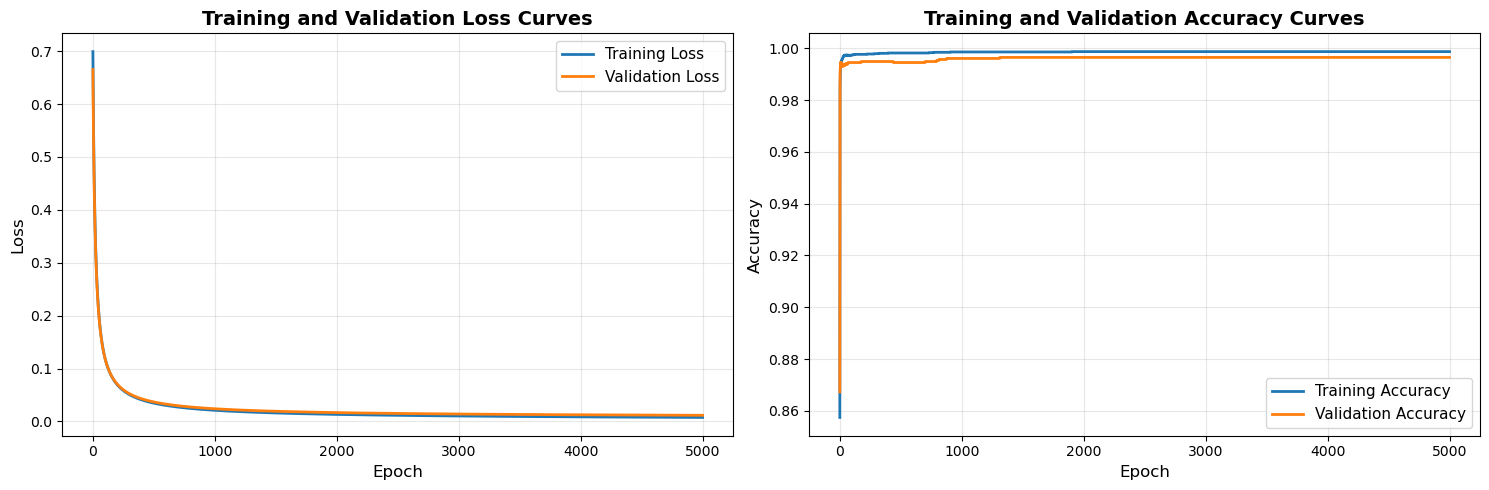

Training converged after 5000 epochs


In [ ]:
# Plot training and validation loss curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', linewidth=2)
plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training and Validation Accuracy Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Final Test Evaluation

Evaluate our model on the test set and create a confusion matrix.


In [ ]:
# Evaluate on test set using DataLoader
test_loss, test_accuracy = evaluate(model, test_loader, compute_loss=True)

print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")


FINAL TEST RESULTS
Test Accuracy: 0.9964 (99.64%)
Test Loss: 0.0117


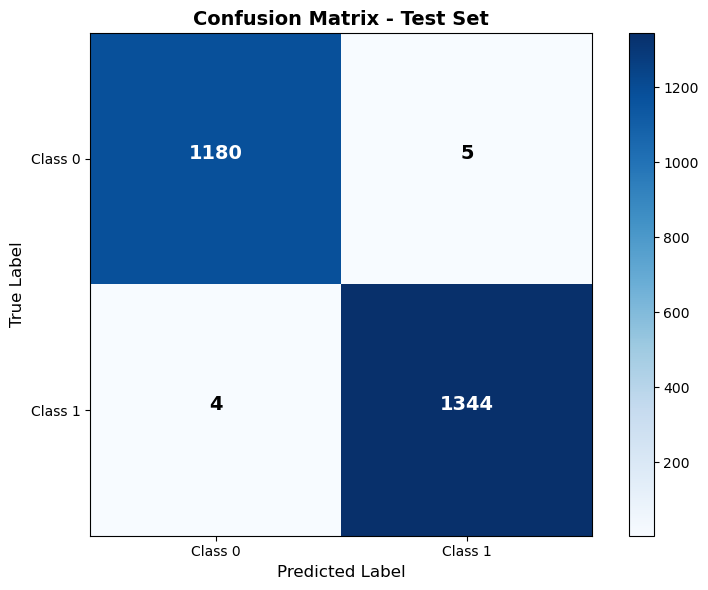


Confusion Matrix:
                Predicted
                0       1
Actual  0      1180      5
        1         4   1344

Interpretation:
- True Negatives (TN): 1180 - Correctly predicted class 0
- False Positives (FP): 5 - Predicted 1 but actually 0
- False Negatives (FN): 4 - Predicted 0 but actually 1
- True Positives (TP): 1344 - Correctly predicted class 1


In [ ]:
# Create confusion matrix (collect predictions from test DataLoader)
y_test_true = []
y_test_pred = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model.predict(batch_X)
        y_test_true.extend(batch_y.numpy())
        y_test_pred.extend(predictions.numpy())

# Convert to numpy arrays for confusion matrix
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

cm = confusion_matrix(y_test_true, y_test_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

